# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://opendata.vancouver.ca/explore/dataset/property-tax-report/table/?refine.report_year=2021). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2021.  

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [9]:
import pandas as pd

df = pd.read_csv("property-tax-report_2021.csv", sep=';')


df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

df['PROPERTY_POSTAL_CODE']

0         V6L 3C7
1         V6L 1B1
2         V6L 2H4
3         V6N 2Y9
4         V6S 1X3
           ...   
650842    V6J 2L5
650843    V5T 0G7
650844    V6J 1L2
650845    V5S 0C9
650846        NaN
Name: PROPERTY_POSTAL_CODE, Length: 650847, dtype: object

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src="img/v6a.png" width="400">

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

<ipython-input-36-54013c8211e4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_B = df_A[df['YEAR_BUILT']>=1900]
<ipython-input-36-54013c8211e4>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_L = df_B[df['LEGAL_TYPE']=="LAND"]


Text(0.5, 1.0, 'Hexbin Plot of Year_Built & House_Price')

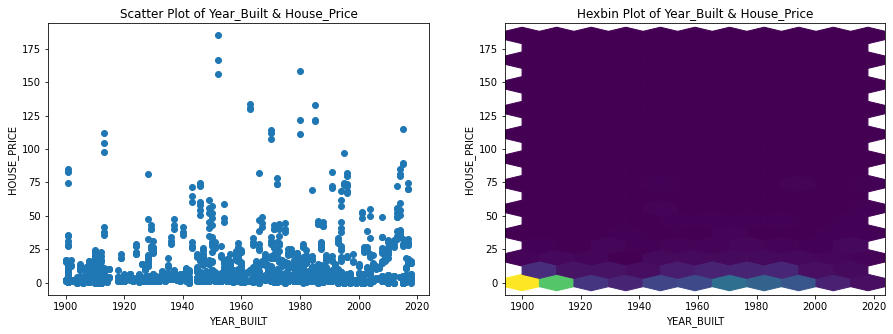

In [36]:
import matplotlib.pyplot as plt

df_A = df[df['PROPERTY_POSTAL_CODE'].fillna('').str.startswith('V6A')]
df_B = df_A[df['YEAR_BUILT']>=1900]
df_L = df_B[df['LEGAL_TYPE']=="LAND"]
#display(df_L.head(20))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
#Scatter plot
ax1.scatter(df_L['YEAR_BUILT'], df_L['HOUSE_PRICE'])
ax1.set_xlabel('YEAR_BUILT')
ax1.set_ylabel('HOUSE_PRICE')
ax1.set_title('Scatter Plot of Year_Built & House_Price')
#Hexbin plot
ax2.hexbin(df_L['YEAR_BUILT'], df_L['HOUSE_PRICE'],gridsize = (10,10),cmap = 'viridis',\
           mincnt= min(df_L['HOUSE_PRICE']))
ax2.set_xlabel('YEAR_BUILT')
ax2.set_ylabel('HOUSE_PRICE')
ax2.set_title('Hexbin Plot of Year_Built & House_Price')


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. A majority of houses are priced at less than 200,000 dollars.
2. The yearly trend in house prices does not appear to vary greatly based on the year of construction.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


In [28]:
def P_25(x):
  return x.quantile(0.25)

In [29]:
def P_50(x):
  return x.quantile(0.50)

In [30]:
def P_75(x):
  return x.quantile(0.75)

Text(0.5, 1.0, 'YEAR_BUILT vs 75TH_HOUSE_PRICE')

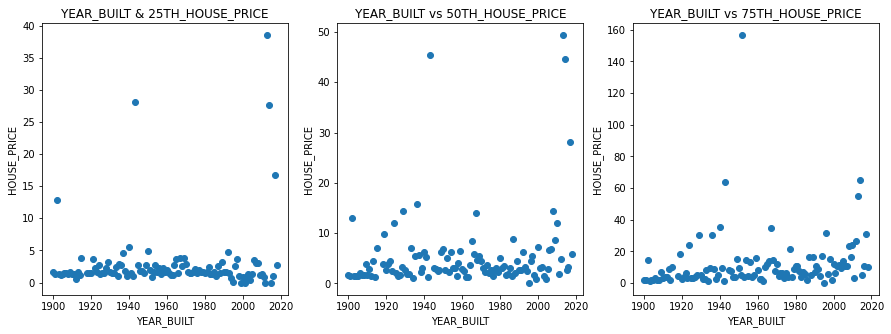

In [38]:
df_B = df_L.groupby(['YEAR_BUILT']).agg({'HOUSE_PRICE': [P_25, P_50, P_75]})

df_b = pd.DataFrame({'YEAR_BUILT':df_B.index, \
                     '25TH_HOUSE_PRICE':df_B['HOUSE_PRICE']['P_25'],\
                     '50TH_HOUSE_PRICE':df_B['HOUSE_PRICE']['P_50'],\
                     '75TH_HOUSE_PRICE':df_B['HOUSE_PRICE']['P_75']\
                     })
df_b.index = range(len(df_b))
#df_b
fig, (axis1, axis2, axis3) = plt.subplots(1, 3,figsize=(15,5))
axis1.scatter(df_b['YEAR_BUILT'], df_b['25TH_HOUSE_PRICE'])
axis2.scatter(df_b['YEAR_BUILT'], df_b['50TH_HOUSE_PRICE'])
axis3.scatter(df_b['YEAR_BUILT'], df_b['75TH_HOUSE_PRICE'])

axis1.set_xlabel('YEAR_BUILT')
axis1.set_ylabel('HOUSE_PRICE')

axis2.set_xlabel('YEAR_BUILT')
axis2.set_ylabel('HOUSE_PRICE')

axis3.set_xlabel('YEAR_BUILT')
axis3.set_ylabel('HOUSE_PRICE')

axis1.set_title('YEAR_BUILT & 25TH_HOUSE_PRICE')
axis2.set_title('YEAR_BUILT vs 50TH_HOUSE_PRICE')
axis3.set_title('YEAR_BUILT vs 75TH_HOUSE_PRICE')


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. Although slightly pricier, older real estate properties do not show a significant increase in cost.
2. The higher percentiles usually exhibit greater variability.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [50]:
import numpy as np
def calc_pearson(df, x, y):
    #<-- Write Your Code -->   
    x_mean = df[x].mean()
    x_std = df[x].std()
    y_mean = df[y].mean()
    y_std = df[y].std()
    xy_mean = (df[x]*df[y]).mean()
    return ((xy_mean-x_mean*y_mean)/(x_std*y_std))

def calc_spearman(df, x, y):
    #<-- Write Your Code -->
    n = len(df)
    df_copy = df.copy()
    df_copy['rank_x'] = (np.argsort(-1*df_copy[x])+1)
    df_copy['rank_y'] = (np.argsort(-1*df_copy[y])+1)
    ans = 1 - 6*np.sum((df_copy['rank_x']-df_copy['rank_y'])**2)/(n*(n**2-1))
    return ans
    


Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [51]:
print(df_b.head(20))
print()

for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(df_b, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(df_b, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

    YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0       1900.0          1.587750          1.695000          2.065475
1       1901.0          1.265425          1.564900          2.032500
2       1902.0         12.822000         13.056000         14.835000
3       1903.0          1.287900          1.475600          1.551200
4       1904.0          1.232250          1.568000          1.821500
5       1905.0          1.405700          1.585300          1.803000
6       1906.0          1.545600          2.154000          3.243700
7       1907.0          1.514250          1.765000          2.196250
8       1908.0          1.398250          1.592000          1.874500
9       1909.0          1.616250          3.890800          6.788400
10      1910.0          1.365000          1.684000          3.050000
11      1911.0          1.350250          2.857500          3.666700
12      1912.0          0.572250          1.556700          4.020250
13      1913.0          1.703125  

Please write down the **two** most interesting findings that you draw from the result.

 

**Findings**
1. The house price and the year of construction have a positive correlation.
2. The higher percentiles have a stronger correlation with the year of construction than the lower percentiles.

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [52]:
df_sample = pd.read_csv("property-tax-report_2021_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

Text(0, 0.5, 'HOUSE_PRICE')

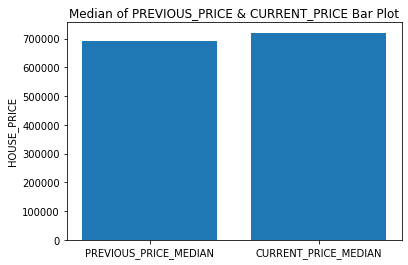

In [53]:
# --- Write your code below ---
previous = df_sample['PREVIOUS_PRICE'].median()
current = df_sample['CURRENT_PRICE'].median()
plt.bar(["PREVIOUS_PRICE_MEDIAN","CURRENT_PRICE_MEDIAN"], [previous,current])
plt.title('Median of PREVIOUS_PRICE & CURRENT_PRICE Bar Plot')
plt.ylabel('HOUSE_PRICE')

### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, compute a 95%-confidence interval for each number, and add the confidence intervals to the above bar chart. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

The confidence interval for previous/current price median is: 
[-28000.  29000.] [-31362.5  27150. ]


Text(0, 0.5, 'HOUSE_PRICE')

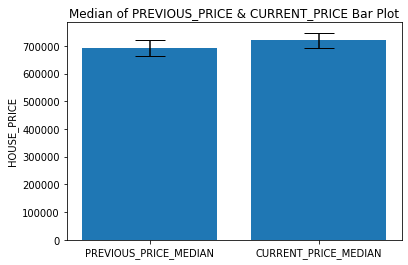

In [58]:
# --- Write your code below ---
n = len(df_sample)
p = []
c = []
for i in range(1000):
    df_temp = df_sample.sample(n,replace=True)
    p.append(df_temp['PREVIOUS_PRICE'].median())
    c.append(df_temp['CURRENT_PRICE'].median())
dif_prev = np.array(p)-previous
dif_curr = np.array(c)-current
prev_25 = np.quantile(dif_prev,0.025)
prev_75 = np.quantile(dif_prev,0.975)
curr_25 = np.quantile(dif_curr,0.025)
curr_75 = np.quantile(dif_curr,0.975)
conf = np.array([[prev_25,prev_75],[curr_25,curr_75]])

print("The confidence interval for previous/current price median is: ")
print(conf[0],conf[1])

plt.bar(["PREVIOUS_PRICE_MEDIAN","CURRENT_PRICE_MEDIAN"], [previous,current],yerr=conf, capsize=15)
plt.title('Median of PREVIOUS_PRICE & CURRENT_PRICE Bar Plot')
plt.ylabel('HOUSE_PRICE')

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.